In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [26]:
df = pd.read_csv('../DataSamples/airline_passengers.csv',
                 index_col='Month',
                 parse_dates=True)

In [27]:
df['LogPassengers'] = np.log(df['Passengers'])

In [28]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [29]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [30]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [31]:
# Make supervised datasets

series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

In [32]:
np.array(X).reshape(-1, T, 1)

array([[[ 0.05218575],
        [ 0.1121173 ],
        [-0.02298952],
        ...,
        [-0.08455739],
        [-0.13353139],
        [-0.13473259]],

       [[ 0.1121173 ],
        [-0.02298952],
        [-0.06402186],
        ...,
        [-0.13353139],
        [-0.13473259],
        [ 0.12629373]],

       [[-0.02298952],
        [-0.06402186],
        [ 0.10948423],
        ...,
        [-0.13473259],
        [ 0.12629373],
        [-0.0257525 ]],

       ...,

       [[ 0.11224286],
        [ 0.02919915],
        [-0.06437866],
        ...,
        [ 0.15067335],
        [-0.02606011],
        [-0.17639854]],

       [[ 0.02919915],
        [-0.06437866],
        [ 0.06916336],
        ...,
        [-0.02606011],
        [-0.17639854],
        [-0.0970834 ]],

       [[-0.06437866],
        [ 0.06916336],
        [ 0.09552712],
        ...,
        [-0.17639854],
        [-0.0970834 ],
        [-0.1672513 ]]])

In [33]:
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)

In [34]:
X.shape

(133, 10, 1)

In [35]:
Y.shape

(133,)

In [36]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [37]:
# RNN
i = Input(shape=(T,1))
x = LSTM(24)(i)
x = Dense(1)(x)
model = Model(i, x)

In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 24)                2496      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(
    loss='mse',
    optimizer='adam'
)

In [40]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest, Ytest)
)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/4 [======>.......................] - ETA: 6s - loss: 0.0111WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fcf068da170> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

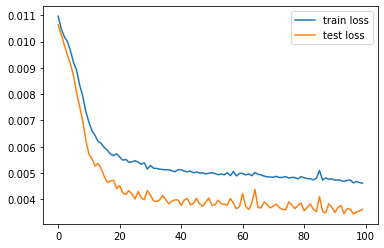

In [41]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [42]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [43]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 19ms/step


In [44]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [45]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [46]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

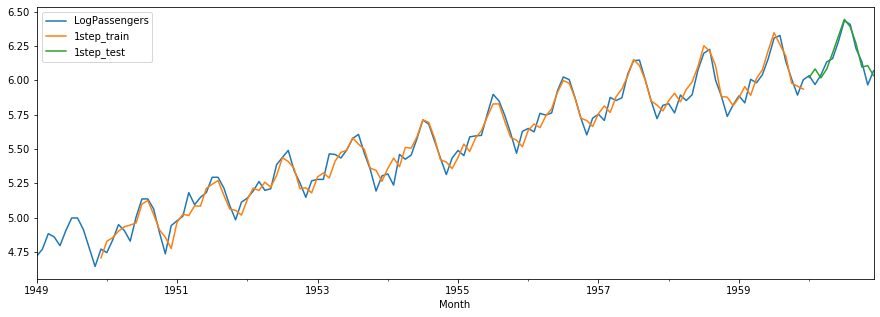

In [47]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15,5));

In [ ]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

In [95]:
while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1, 1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [58]:
# save multistep forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

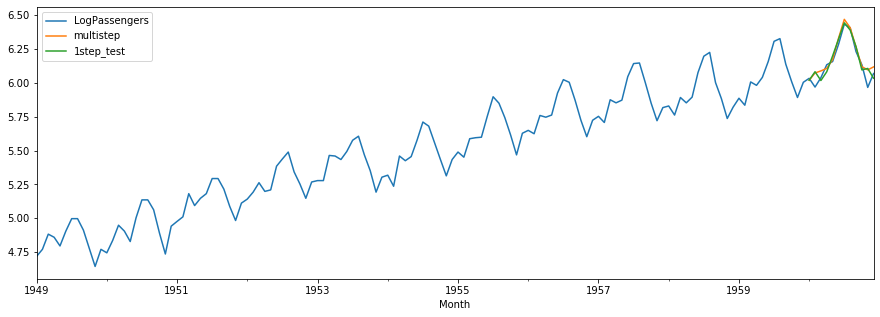

In [59]:
cols = ['LogPassengers', 'multistep', '1step_test']
df[cols].plot(figsize=(15, 5));

In [64]:
# make multi-output supervised dataset
Tx = T # number of step in the input
Ty = Ntest # number of steps in the output
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [69]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [70]:
# RNN
i = Input(shape=(Tx, 1))
x = LSTM(24, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i,x)

In [71]:
check_point = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

In [72]:
model.compile(
    loss='mse',
    optimizer='adam'
)

In [73]:
r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m, Ytest_m),
    callbacks=[check_point],
)

Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/4 [======>.......................] - ETA: 4s - loss: 0.0119WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fcf0a899ef0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

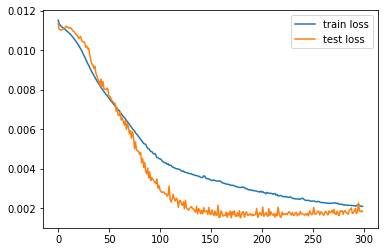

In [74]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [75]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [76]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 19ms/step


In [77]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [78]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [79]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
    np.cumsum(Ptest)

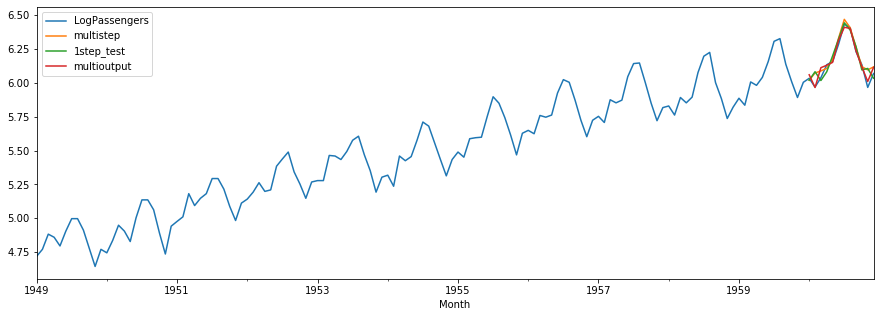

In [80]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15,5));

In [81]:
# RNN with multiple LSTM layers
i = Input(shape=(Tx, 1))
x = LSTM(16, return_sequences=True)(i)
x = LSTM(16, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [83]:
check_point = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

In [84]:
model.compile(
    loss='mse',
    optimizer='adam'
)

In [85]:
r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m, Ytest_m),
    callbacks=[check_point],
)

Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/4 [======>.......................] - ETA: 9s - loss: 0.0118WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fcf0cbb0320> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full outp

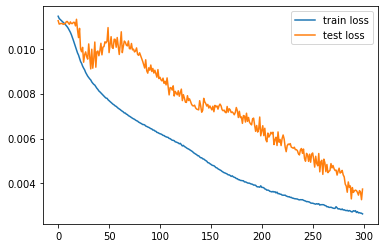

In [87]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [88]:
best_model = tf.keras.models.load_model('best_model.h5')

In [89]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 19ms/step


In [90]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [92]:
df.loc[test_idx, 'multioutput2'] = last_train + \
    np.cumsum(Ptest)

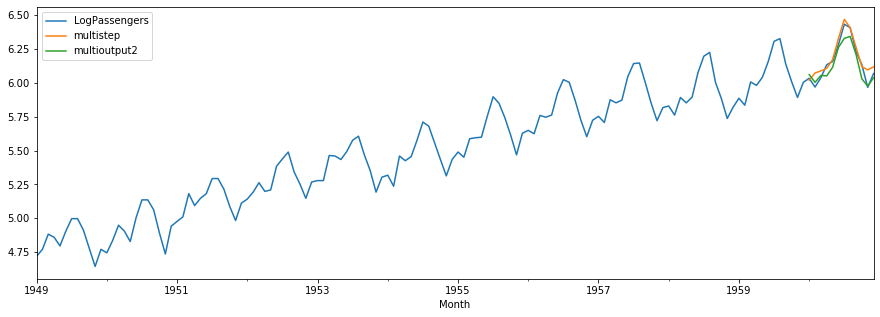

In [93]:
cols = ['LogPassengers','multistep','multioutput2']
df[cols].plot(figsize=(15,5));

In [95]:
# MAPE
from sklearn.metrics import mean_absolute_percentage_error

test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep']
)
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput']
)
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2']
)
print("multi-output2 MAPE:", mape3)

multi-step MAPE: 0.007041970900320012
multi-output MAPE: 0.003840486483209404
multi-output2 MAPE: 0.007505303442728327
